In [235]:
import zipfile
import pandas as pd
import hashlib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import requests

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.0f}'.format)

In [233]:
%reset -f

In [236]:
data = pd.read_parquet('/home/vfaybusovich/auto_data_anonymized.parquet',engine = 'fastparquet')

holidays = pd.read_excel('/home/vfaybusovich/Даты праздники.xlsx')
holidays['Holidays'] = pd.to_datetime(holidays['Holidays'], format='%Y.%m.%d')

ekb_temperature = pd.read_csv('/home/vfaybusovich/ekaterinburg_weather_simple_2024_2025.csv')

### Обработка столбцов, генерация фичей

##### Работа с хэшами

In [237]:
# Фиксированный маппинг для Category3
category3_mapping = {'50d781e81c84': '1', 'd432d4e7d777': '2', 'f7b2265c54bb': '3', '5adc0d536016': '4'}

# Фиксированный маппинг для Category4
category4_mapping = {'1923d114c6e7': '1', 'ad208898794e': '2', '8f159c52c4d2': '3', '71425d676ee9': '4', 'a8a6e35b1dfe': '5', '5407c818b193': '6', 'a4418d534611': '7', '6c0dcb86e692': '8', '4e0438204ff2': '9', '6051924bf61a': '10', '24a09c522059': '11', 'a640dfac39e1': '12', 'b46259b17bdf': '13', '3081126e9501': '14', '84333420e3f7': '15', 'a5542e4bee0e': '16', 'ff2c65c331d5': '17', '9e9dd38e3fbe': '18', '4b4418beff11': '19', 'a162e29a63de': '20', 'dc9f3331b9cf': '21', '5a3728d08af0': '22', '4d9408fe4f54': '23', '23ecf8c0ce99': '24', 'b6e14493cd29': '25', '65f7bd03a732': '26'}

# Применяем маппинг
data['Category3'] = data['Category3'].map(category3_mapping)
data['Category4'] = data['Category4'].map(category4_mapping)

##### Создание временных фичей 

In [238]:
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['dayofweek'] = data['Date'].dt.dayofweek + 1
data['week'] = data['Date'].dt.isocalendar().week
data['quarter'] = data['Date'].dt.quarter
data['dayofyear'] = data['Date'].dt.dayofyear
data['is_holiday'] = data['Date'].isin(holidays['Holidays']).astype(int)

##### Создание фичи с температурой воздуха 
### (НЕ ГОТОВО ДО КОНЦА)

Нужно распарсить данные по средней температуре в основных регионах доставки товаров. Это может быть очень крутой фичей. Даты и время всего лишь прокси от погоды за окном, особенно в случае товаров из категории автохимии и машинных масел.

Основные города (регионы) доставки товаров:
- Юг (Ростов-на-Дону)
- Поволжье (Самара)
- Москва и Московская область
- Урал (Екатеринбург) - готово
- Центр (Тверь)
- Сибирь (Новосибирск)
- Санкт-Петербург 

In [243]:
# данная часть кода будет ещё доподняться информацией по различным городам, т.к. у меня не хватило дневного лимита по API

ekb_temperature

,date,temperature_avg,conditions
0,2024-01-01,-12,"Снег, Пасмурная погода"
1,2024-01-02,-23,"Снег, Частично облачно"
2,2024-01-03,-27,"Снег, Частично облачно"
3,2024-01-04,-19,"Снег, Пасмурная погода"
4,2024-01-05,-17,"Снег, Частично облачно"
...,...,...,...
726,2025-12-27,-13,Частично облачно
727,2025-12-28,-12,Частично облачно
728,2025-12-29,-11,Частично облачно
729,2025-12-30,-13,Частично облачно


In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42763974 entries, 0 to 42763973
Data columns (total 20 columns):
 #   Column          Dtype         
---  ------          -----         
 0   YYYYMM          int64         
 1   Date            datetime64[ns]
 2   Category3       object        
 3   Category4       object        
 4   Brand           object        
 5   SupplierID      object        
 6   SellerID        object        
 7   SKU_ID          object        
 8   is_promo        int8          
 9   stock_qty       int64         
 10  GMV_wo_VAT      float64       
 11  GMV_wo_VAT_Acc  float64       
 12  Items_Acc       int64         
 13  month           int32         
 14  day             int32         
 15  dayofweek       int32         
 16  week            UInt32        
 17  quarter         int32         
 18  dayofyear       int32         
 19  is_holiday      int64         
dtypes: UInt32(1), datetime64[ns](1), float64(2), int32(5), int64(4), int8(1), object(6)
memo

## Описание данных

---

В нашем датасете 42.7 млн строк. Данные содержат информацию о продажах товаров одного из маркетплейсов.

- Выбранные категории — автомобильные масла и автохимия
- Временной горизонт — с января 2024 по сентябрь 2025

**Описание колонок:**
- YYYYMM — дата в формате ГОДМЕСЯЦ
- Date — дата в формате 'YYYY-MM-DD'
- Category3 — категория 3-го уровня. Всего таких категорий четыре: 'Дополнительная авто-мото химия', 'Масла автомобильные', 'Технические автомобильные жидкости' и 'Товары для детейлинга'
- Category4 — категория 4-го уровня. Всего таких категорий 26. Например, 'Автохимия - Трансмиссионное, гидравлическое масла', 'Автохимия - Антифриз, тосол', 'Автохимия - Герметик, клей' и тд
- Brand — бренд товара. Всего в нашем датасете 3615 уникальных брендов
- SupplierID — айди поставщика, который поставляет товар. Всего в нашем датасете 8014 уникальных поставщиков
- SellerID — айди магазина, который продаёт товар. Всего в нашем датасете 8476 уникальных магазинов
- SKU_ID — айди товара. Всего в нашем датасете около 400 тыс. уникальных товаров
- is_promo — бинарная переменная. Признак участия товара в промо в данный день (1 - товар участвовал в промо, 0 - не участвовал)
- stock_qty — объём товаров на складе в определенную дату
- GMV_wo_VAT — товарооборот (D-R) в рублях без НДС. (D-R) - это (Delivered - Returned), т.е. товарооборот доставленных заказов за вычетом возвратов
- GMV_wo_VAT_Acc — товарооборот (Acc) в рублях без НДС. (Acc) - это только принятые заказы
- Items_Acc — объём принятых заказов в штуках
- month - номер месяца в году
- day - номер дня в месяце
- dayofweek - номер дня в неделе (1 - понедельник, 7 - воскресенье)
- week - номер недели в году
- quarter - номер квартала
- dayofyear - номер дня в году
- is_holiday - бинарная колонка, признак выходного. Если 1 - выходной день, если 0 - то день рабочий

---

##### Ответы на основные вопросы

- В чём разница между SupplierID и SellerID? — Поставщик - это компания, которая поставляет товары на склад. Магазин - лицо, которое продаёт конечному потребителю. Например, компания занимается продажей электроники, продаёт бренды Samsung и Apple. Такая компания может захотеть продавать товары различных брендов от имени различных магазинов - 'Иванов оригинальная техника Apple' и 'Иванов оригинальная техника Samsung'. В таких случаях у товаров будет один и тот же SupplierID, но различные SellerID.
- Может ли одна SKU_ID принадлежать различным магазинам? — Нет, не может. SKU_ID уникальна и принадлежит только одному магазину, поставщику.

In [240]:
data.head()

,YYYYMM,Date,Category3,Category4,Brand,SupplierID,SellerID,SKU_ID,is_promo,stock_qty,GMV_wo_VAT,GMV_wo_VAT_Acc,Items_Acc,month,day,dayofweek,week,quarter,dayofyear,is_holiday
0,202403,2024-03-12,1,1,6508a73ebac8,65e62f472bd92a6f,b9cfe94c443befd0,947ab87002d31c11,0,19998,0,0,0,3,12,2,11,1,72,0
1,202401,2024-01-14,1,1,67771d69b882,b63cf0f9b6051d0b,4404f6af3305c5f8,dded405a5c30d721,0,399,0,0,0,1,14,7,2,1,14,1
2,202408,2024-08-02,1,1,0d91cc0c250b,caf6c8a555903af1,57c308d216a90662,489182415802ae6f,0,6,0,0,0,8,2,5,31,3,215,0
3,202405,2024-05-30,1,2,509ba933df70,62138f0575058410,4f48c550da9f0b4f,a71cf1b58bff7b3a,0,20,0,0,0,5,30,4,22,2,151,0
4,202406,2024-06-21,1,1,0d91cc0c250b,caf6c8a555903af1,57c308d216a90662,84f394b1db4c084c,0,5,0,0,0,6,21,5,25,2,173,0


### Обработка пропусков

- В нашем датасете есть пропуски в столбце Brand. Всего таких записей 2431. Пропуски в брендах составляют всего 0.006% данных и 0.005% оборота. Почти весь оборот без брендов (1.6 млн руб. из 1.8 млн) приходится на один товар. Рекомендуется исключить эти данные из анализа.

In [211]:
data.isna().sum()

# Смотрим на пропуски в брендах
brand_missing = data[data['Brand'].isna()]

print('Строки без бренда:')
print(f'Всего: {len(brand_missing):,}')
print(f'Это {len(brand_missing)/len(data)*100:.1f}% от всех данных')
print()

print('В каких категориях нет брендов:')
category_counts = brand_missing['Category3'].value_counts()
for cat, cnt in category_counts.items():
    print(f'  {cat}: {cnt:,}')
print()

print('Считаем уникальные товары и поставщиков:')
print(f'Уникальных товаров без бренда: {brand_missing["SKU_ID"].nunique():,}')
print(f'Поставщиков без брендов: {brand_missing["SupplierID"].nunique():,}')
print(f'Магазинов без брендов: {brand_missing["SellerID"].nunique():,}')
print()

print('Оборот по строкам без бренда:')
total_sales = brand_missing['GMV_wo_VAT_Acc'].sum()
total_orders = brand_missing['Items_Acc'].sum()
print(f'Общий оборот: {total_sales:,.0f} руб.')
print(f'Количество заказов: {total_orders:,} шт.')
print()

# Сравниваем с общими цифрами
all_sales = data['GMV_wo_VAT_Acc'].sum()
print(f'Оборот без брендов от общего: {total_sales/all_sales*100:.3f}%')
print()

print('Самые продаваемые товары без бренда:')
top_items = brand_missing.groupby('SKU_ID').agg({
    'GMV_wo_VAT_Acc': 'sum',
    'Items_Acc': 'sum'
}).sort_values('GMV_wo_VAT_Acc', ascending=False).head(5)

for item_id, row in top_items.iterrows():
    sales = row['GMV_wo_VAT_Acc']
    orders = row['Items_Acc']
    print(f'  Товар {item_id}: {sales:,.0f} руб., {orders:,} заказов')

Строки без бренда:
Всего: 0
Это 0.0% от всех данных

В каких категориях нет брендов:

Считаем уникальные товары и поставщиков:
Уникальных товаров без бренда: 0
Поставщиков без брендов: 0
Магазинов без брендов: 0

Оборот по строкам без бренда:
Общий оборот: 0 руб.
Количество заказов: 0 шт.

Оборот без брендов от общего: 0.000%

Самые продаваемые товары без бренда:

В какие месяцы больше всего пропусков:


In [193]:
# Удаляем строки с пропущенными брендами
data = data[data['Brand'].notna()]

data.isna().sum()

YYYYMM            0
Date              0
Category3         0
Category4         0
Brand             0
SupplierID        0
SellerID          0
SKU_ID            0
is_promo          0
stock_qty         0
GMV_wo_VAT        0
GMV_wo_VAT_Acc    0
Items_Acc         0
dtype: int64

## Визуализация и поиск инсайтов в данных

### Анализ динамики GMV в рамках месяцев:

---

- В данных заметны определенные тенденции и сезонности

- **GMV устойчиво растёт** с января по сентябрь в 24 и 25 годах  
- **Сезонные скачки GMV** с февраля по апрель  
  *MoM март 2024 = 1.29, MoM март 25 = 1.37*  
  *MoM апрель 24 = 1.26, MoM апрель 25 = 1.18*
- **GMV стагнирует** с апреля по июнь в каждом из годов и  **продолжает рост** начиная с июля

---

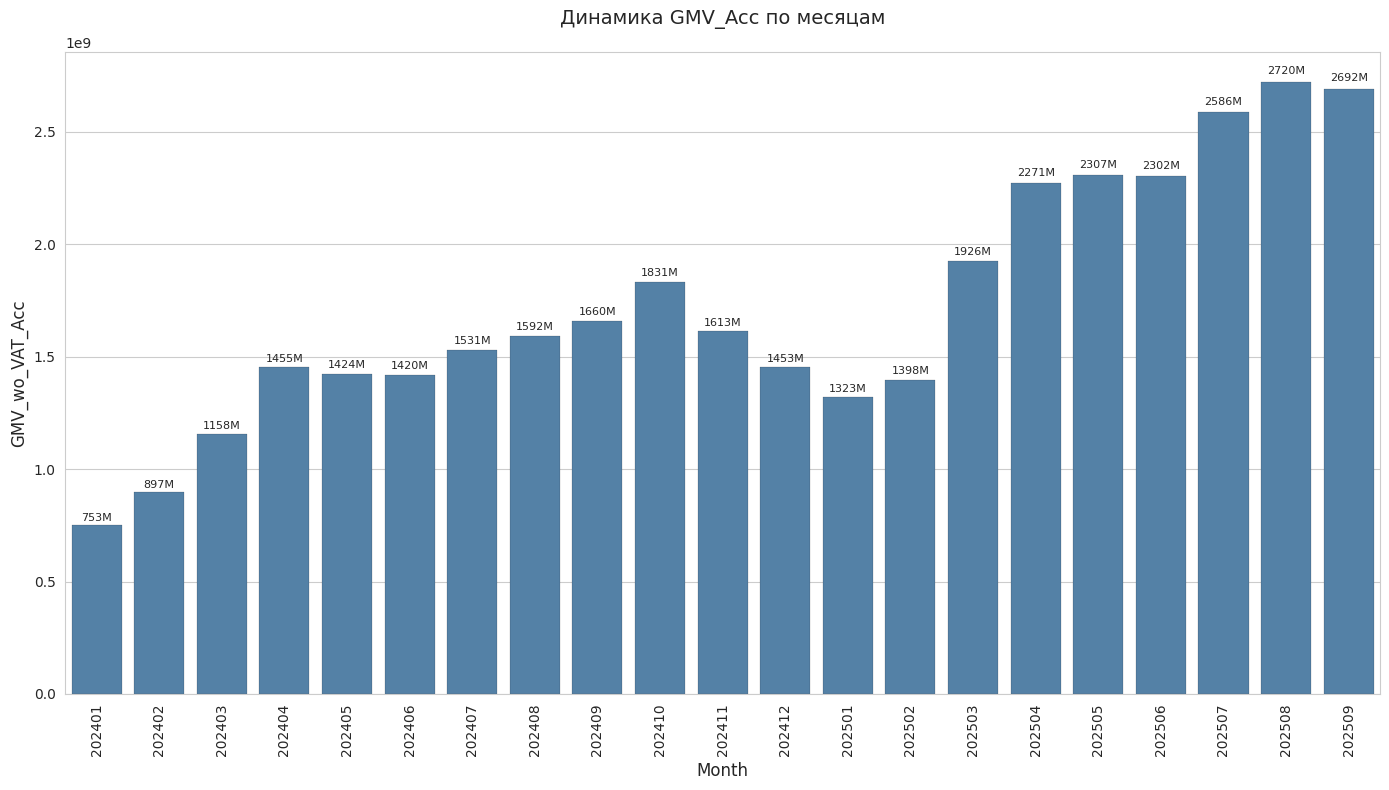

In [194]:
# Создаем временной ряд по месяцам
monthly_gmv = data.groupby('YYYYMM')['GMV_wo_VAT_Acc'].sum().reset_index()

# Настройка стиля
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Строим барплот
ax = sns.barplot(
    data=monthly_gmv,
    x='YYYYMM',
    y='GMV_wo_VAT_Acc',
    color='steelblue',
    edgecolor='black',
    linewidth=0.1
)

# Настройка внешнего вида
plt.title('Динамика GMV_Acc по месяцам', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('GMV_wo_VAT_Acc', fontsize=12)

# Добавляем подписи значений на столбцах
for i, value in enumerate(monthly_gmv['GMV_wo_VAT_Acc']):
    ax.text(i, value + value * 0.01, f'{value/1e6:.0f}M', 
            ha='center', va='bottom', fontsize=8, rotation=0)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Аналитика в разрезе категорий 3-го уровня

---

- Можно заметить, что оборот между категориями 3-го уровня распределен неравномерно. Категория №2 занимает около 50% оборота. На втором месте идёт категория №1 со средней долей около 24%.
- Посмотрев на линейный график, можно предположить высокую положительную корреляцию между категориями №1 и №4. Их движения сонаправленны во времени. В целом создается впечатление, что все категории 3-го уровня имеют достаточно высокую положительную корреляцию. В дальнейшем проверим это предположение с помощью матрицы корреляций.

---

<Figure size 1400x800 with 0 Axes>

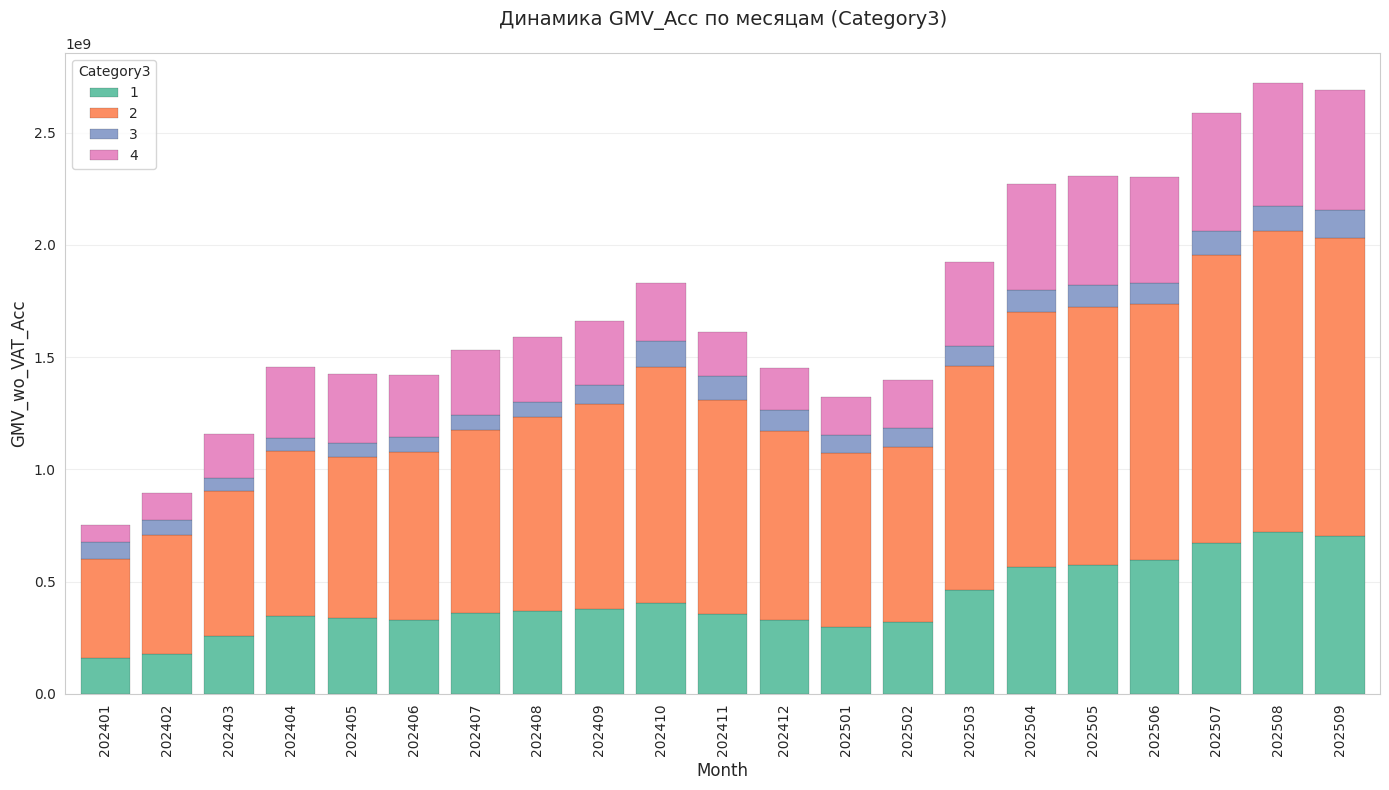

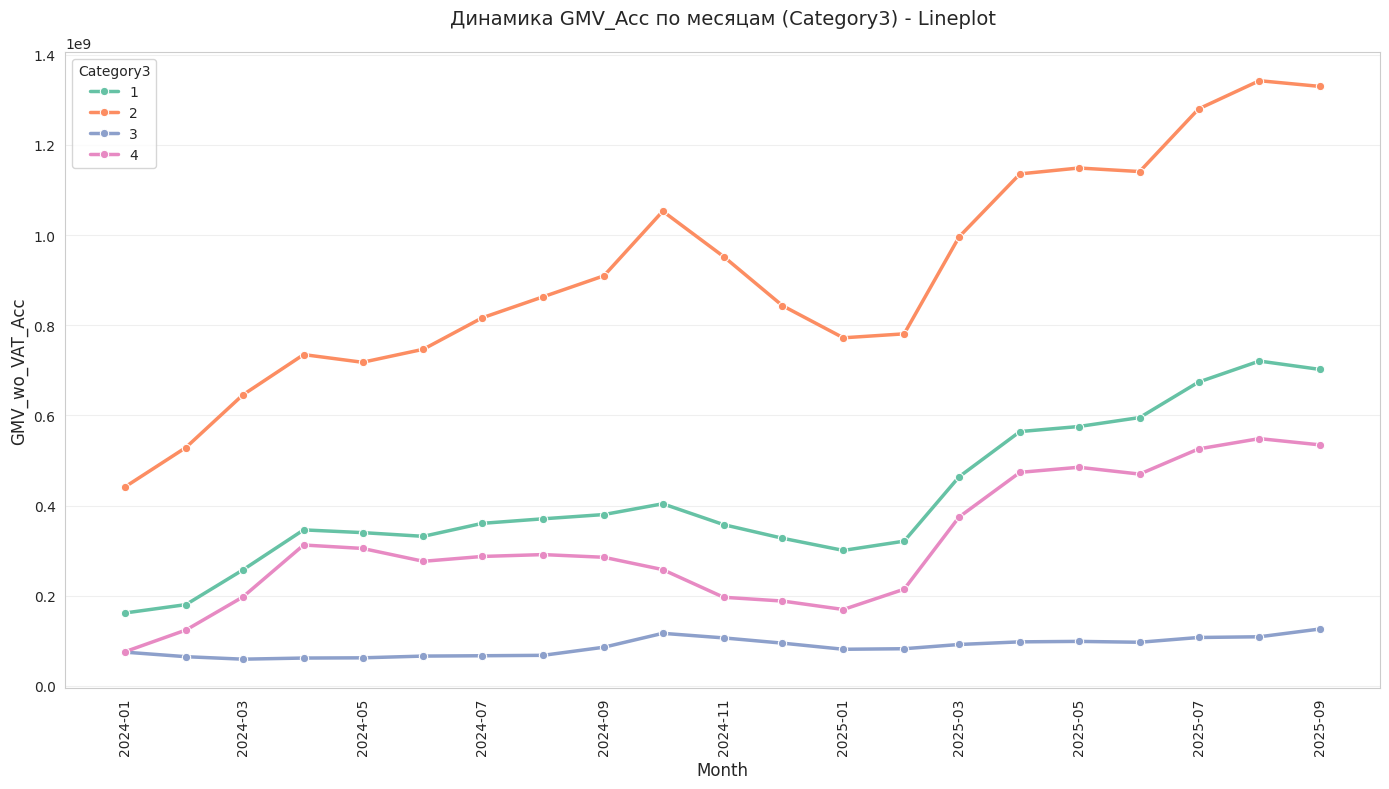

In [204]:
monthly_category3 = data.groupby(['YYYYMM', 'Category3'])['GMV_wo_VAT_Acc'].sum().reset_index()

pivot_category3 = monthly_category3.pivot(
    index='YYYYMM', 
    columns='Category3', 
    values='GMV_wo_VAT_Acc'
).fillna(0)

# Настройка стиля
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
colors = sns.color_palette("Set2", len(pivot_category3.columns))

# Строим stacked barplot с увеличенной шириной столбцов
ax = pivot_category3.plot(
    kind='bar',
    stacked=True,
    color=colors,
    edgecolor='black',
    linewidth=0.1,
    figsize=(14, 8),
    width=0.8  
)

# Настройка внешнего вида
plt.title('Динамика GMV_Acc по месяцам (Category3)', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('GMV_wo_VAT_Acc', fontsize=12)

# Убираем вертикальные линии сетки
ax.grid(True, axis='y', alpha=0.3)
ax.grid(False, axis='x')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



# Строим lineplot с hue по Category3
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Преобразуем YYYYMM в datetime для корректного отображения
monthly_category3['Date'] = pd.to_datetime(monthly_category3['YYYYMM'], format='%Y%m')

ax = sns.lineplot(
    data=monthly_category3,
    x='Date',
    y='GMV_wo_VAT_Acc',
    hue='Category3',
    palette='Set2',
    linewidth=2.5,
    marker='o',
    markersize=6
)

# Настройка внешнего вида
plt.title('Динамика GMV_Acc по месяцам (Category3) - Lineplot', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('GMV_wo_VAT_Acc', fontsize=12)

# Убираем вертикальные линии сетки
ax.grid(True, axis='y', alpha=0.3)
ax.grid(False, axis='x')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [214]:
# Создаем сводную таблицу с долями для Category3
pivot_category3_pct = monthly_category3.pivot(
    index='YYYYMM', 
    columns='Category3', 
    values='GMV_wo_VAT_Acc'
).fillna(0)

# Вычисляем доли в процентах от общего оборота по месяцам
pivot_category3_pct = pivot_category3_pct.div(monthly_gmv.set_index('YYYYMM')['GMV_wo_VAT_Acc'], axis=0) * 100
pivot_category3_pct = pivot_category3_pct.round(1)

# Для Category3 с стилизацией
def style_percentage(val):
    return f"{val}%"

styled_category3 = pivot_category3_pct.style\
    .format(style_percentage)\
    .background_gradient(cmap='Blues', axis=1, vmin=0, vmax=65)\
    .set_properties(**{'width': '70px'})

styled_category3

Category3,1,2,3,4
YYYYMM,,,,
202401,21.5%,58.6%,9.9%,10.0%
202402,20.1%,58.9%,7.2%,13.8%
202403,22.2%,55.7%,5.1%,17.0%
202404,23.8%,50.5%,4.2%,21.5%
202405,23.9%,50.4%,4.4%,21.4%
202406,23.3%,52.6%,4.6%,19.4%
202407,23.5%,53.3%,4.4%,18.7%
202408,23.3%,54.2%,4.2%,18.3%
202409,22.9%,54.8%,5.2%,17.2%


### Аналитика в разрезе категорий 4-го уровня

---

Можно заметить

---

<Figure size 1400x800 with 0 Axes>

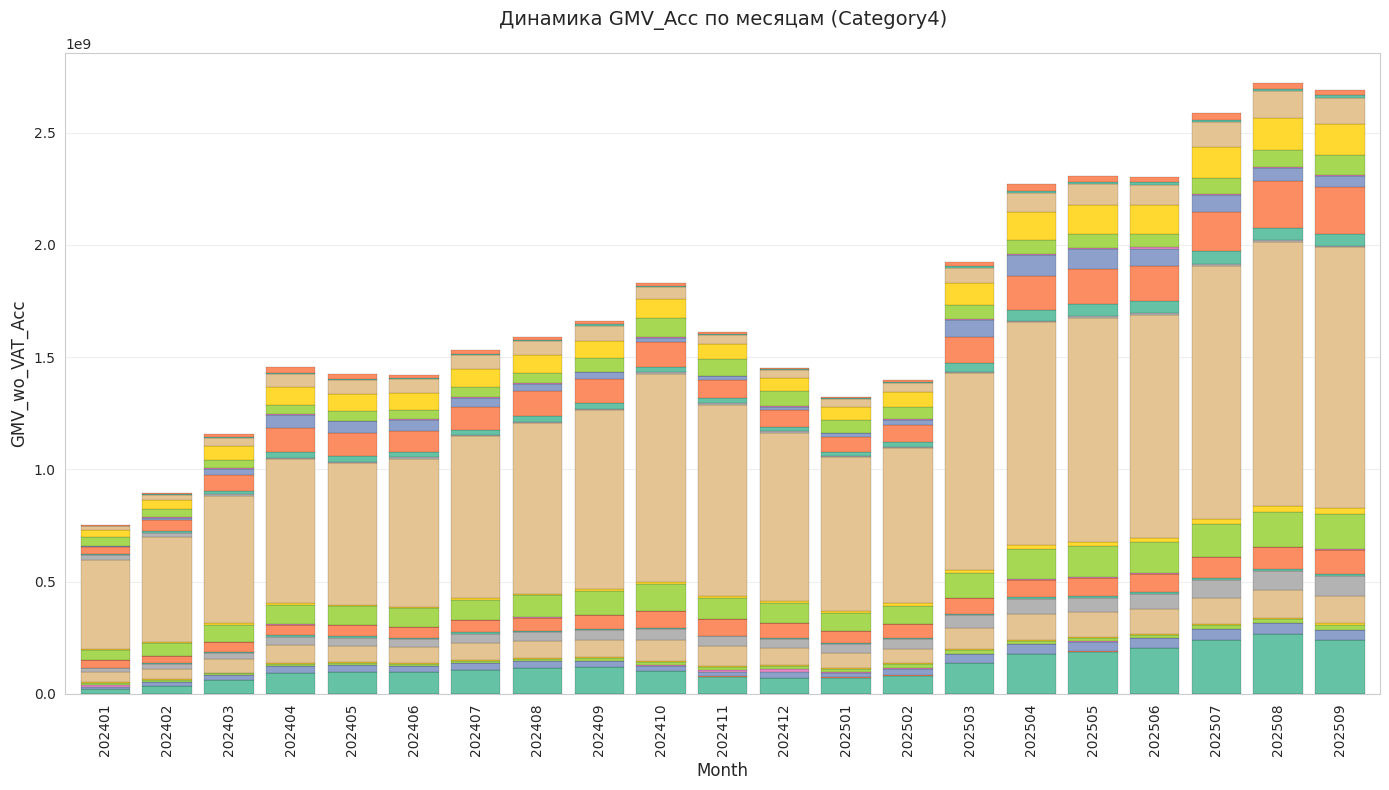

In [136]:
monthly_category4 = data.groupby(['YYYYMM', 'Category4'])['GMV_wo_VAT_Acc'].sum().reset_index()

pivot_category4 = monthly_category4.pivot(
    index='YYYYMM', 
    columns='Category4', 
    values='GMV_wo_VAT_Acc'
).fillna(0)

# Настройка стиля
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
colors = sns.color_palette("Set2", len(pivot_category4.columns))

# Строим stacked barplot с увеличенной шириной столбцов
ax = pivot_category4.plot(
    kind='bar',
    stacked=True,
    color=colors,
    edgecolor='black',
    linewidth=0.1,
    figsize=(14, 8),
    width=0.8,
    legend = False
)

# Настройка внешнего вида
plt.title('Динамика GMV_Acc по месяцам (Category4)', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('GMV_wo_VAT_Acc', fontsize=12)

# Убираем вертикальные линии сетки
ax.grid(True, axis='y', alpha=0.3)
ax.grid(False, axis='x')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()